### To answer Reviewer #2 question regarding the sequence similarity of the DMIs used in the PRS, I will compute the pairwise sequence similarity between all combinations of domains used in the PRS.

In [1]:
from Bio import pairwise2
from Bio.Seq import Seq
import os, db_utils, itertools
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/'

In [8]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [16]:
query = """select distinct prediction_name from chopyan_db.AlphaFold_prediction_result
where run_id = 'run37' and project_name = 'AlphaFold_benchmark';"""

with connect.cursor() as cursor:
    cursor.execute(query)
    data = cursor.fetchall()
fasta_files = [data[0] for data in data]
print(len(fasta_files))

136


In [20]:
root_path = '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run37'
fasta_domain_seqs = {}

for fasta_file in fasta_files:
    abs_path = f'{root_path}/{fasta_file}.fasta'
    domain_seq = ''
    with open(abs_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    for line in lines[1:]: # skips the first > which is the identifier for the domain
        if line[0] == '>': # stops as soon as it encounters the identifier for the motif
            break
        domain_seq += line
    fasta_domain_seqs[fasta_file] = domain_seq
print(len(fasta_domain_seqs))
fasta_domain_seqs

136


{'run37_DEG_APCC_KENBOX_2_4GGD': 'CRYIPSLPDRILDAPEIRNDYYLNLVDWSSGNVLAVALDNSVYLWSASSGDILQLLQMEQPGEYISSVAWIKEGNYLAVGTSSAEVQLWDVQQQKRLRNMTSHSARVGSLSWNSYILSSGSRSGHIHHHDVRVAEHHVATLSGHSQEVCGLRWAPDGRHLASGGNDNLVNVWPSAPGEGGWVPLQTFTQHQGAVKAVAWCPWQSNVLATGGGTSDRHIRIWNVCSGACLSAVDAHSQVCSILWSPHYKELISGHGFAQNQLVIWKYPTMAKVAELKGHTSRVLSLTMSPDGATVASAAADETLRLWRCFELD',
 'run37_DEG_COP1_1_5IGO': 'RYSRLRVIAEIRHGDIFHSANIVSSIEFDRDDELFATAGVSRCIKVFDFSSVVNEPADMQCPIVEMSTRSKLSCLSWNKHEKNHIASSDYEGIVTVWDVTTRQSLMEYEEHEKRAWSVDFSRTEPSMLVSGSDDCKVKVWCTRQEASVINIDMKANICCVKYNPGSSNYIAVGSADHHIHYYDLRNISQPLHVFSGHKKAVSYVKFLSNNELASASTDSTLRLWDVKDNLPVRTFRGHTNEKNFVGLTVNSEYLACGSETNEVYVYHKEITRPVTSHRFGSPDMDDAEEEAGSYFISAVCWKSDSPTMLTANSQGTIKVLVLAA',
 'run37_DEG_Kelch_Keap1_1_2FLU': 'GRLIYTAGGYFRQSLSYLEAYNPSDGTWLRLADLQVPRSGLAGCVVGGLLYAVGGRNNSPDGNTDSSALDCYNPMTNQWSPCAPMSVPRNRIGVGVIDGHIYAVGGSHGCIHHNSVERYEPERDEWHLVAPMLTRRIGVGVAVLNRLLYAVGGFDGTNRLNSAECYYPERNEWRMITAMNTIRSGAGVCVLHNCIYAAGGYDGQDQLNSVERYDVETETWTFVAPMKHRRSALGITVHQGRIYVLGGYDGHTFLDSVECYDPD

In [26]:
len(list(itertools.combinations(fasta_domain_seqs.values(),2)))

9180

In [28]:
def compute_sequence_similarity(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1,seq2)
    alignment_scores = [aln.score for aln in alignments]
    longest_seq_length = np.max([len(seq1),len(seq2)])
    max_score = np.max(alignment_scores)
    return max_score / longest_seq_length

In [64]:
seq_similarity = []
same_seq = []
for seq1, seq2 in itertools.combinations(fasta_domain_seqs.values(),2):
    similarity = compute_sequence_similarity(seq1,seq2)
    seq_similarity.append(similarity)
    if similarity == 1.0:
        same_seq.append(seq1)
len(seq_similarity)

9180

In [79]:
for k, v in fasta_domain_seqs.items():
    if v in same_seq:
        print(f'-{k}: {v}')

-run37_DOC_USP7_MATH_1_3MQS: TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW
-run37_DOC_USP7_MATH_2_1YY6: TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW
-run37_LIG_LYPXL_SIV_4_2XS1: ATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEELSKLRRAAVGRPLDKHEGALETLLRYYDQICSIEPKFPFSENQICLTFTWKDAFDKGSLFGGSVKLALASLGYEKSCVLFNCAALASQIAAEQNLDNDEGLKIAAKHYQFASGAFLHIKETVLSALSREPTVDISPDTVGTLSLIMLAQAQEVFFLKATRDKMKDAIIAKLANQAADYFGDAFKQCQYKDTLPKEVFPVLAAKHCIMQANAEYHQSILAKQQYYFGEEIARLQHAAELIKTVASRYDEYVNVKDFSDKINRALAAAKKDNDFIYHDRVPDLKDLDPIGKATLVKSTPVNVPISQKFTDLFEKMVPVSVQQSLAAYNQRKADLVNRSIAQMREATTLANGVLASLNLPAAIEDVSGDTVPQSILTKSRSVIEQGGIQTVDQLIKELPELLQRNREILDESLRLLDEEEATDNDLRAKFKERWQRTPSNELYKPLRAEGTNFRTVLDKAVQADGQVKECYQSHRDTIVLLCKPEPELNAAIPSANPAKTMQGSEVVNVLKSLLSNLDEVKKEREGLENDLKSVNFDMTSKFLTALAQDGVINEEALSVTELDRVYGGLTTKVQESLKKQEGLL

In [77]:
np.array(list(itertools.combinations(fasta_domain_seqs.values(),2)))[np.where(np.array(seq_similarity) == 1)]

array([['TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW',
        'TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW'],
       ['ATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEELSKLRRAAVGRPLDKHEGALETLLRYYDQICSIEPKFPFSENQICLTFTWKDAFDKGSLFGGSVKLALASLGYEKSCVLFNCAALASQIAAEQNLDNDEGLKIAAKHYQFASGAFLHIKETVLSALSREPTVDISPDTVGTLSLIMLAQAQEVFFLKATRDKMKDAIIAKLANQAADYFGDAFKQCQYKDTLPKEVFPVLAAKHCIMQANAEYHQSILAKQQYYFGEEIARLQHAAELIKTVASRYDEYVNVKDFSDKINRALAAAKKDNDFIYHDRVPDLKDLDPIGKATLVKSTPVNVPISQKFTDLFEKMVPVSVQQSLAAYNQRKADLVNRSIAQMREATTLANGVLASLNLPAAIEDVSGDTVPQSILTKSRSVIEQGGIQTVDQLIKELPELLQRNREILDESLRLLDEEEATDNDLRAKFKERWQRTPSNELYKPLRAEGTNFRTVLDKAVQADGQVKECYQSHRDTIVLLCKPEPELNAAIPSANPAKTMQGSEVVNVLKSLLSNLDEVKKEREGLENDLKSVNFDMTSKFLTALAQDGVINEEALSVTELDRVYGGLTTKVQESLKKQEGLLKNIQVSHQEFSKMKQSNNEANLREEVLKNLATAYDNFVELVANLKEGTKFYNELT

There are 7 pairwsie domain sequence similarity that returned 100% similarity. They are from the following DMIs:
- run37_DOC_USP7_MATH_1_3MQS: (MATH domain) TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW
- run37_DOC_USP7_MATH_2_1YY6: (MATH domain) TSWRSEATFQFTVERFSRLSESVLSPPCFVRNLPWKIMVMPRFYPDRPHQKSVGFFLQCNAESDSTSWSCHAQAVLKIINYRDDEKSFSRRISHLFFHKENDWGFSNFMAWSEVTDPEKGFIDDDKVTFEVFVQADAPHGVAW
- run37_LIG_LYPXL_SIV_4_2XS1: (ALIX V-shaped domain binding to HIV) ATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEELSKLRRAAVGRPLDKHEGALETLLRYYDQICSIEPKFPFSENQICLTFTWKDAFDKGSLFGGSVKLALASLGYEKSCVLFNCAALASQIAAEQNLDNDEGLKIAAKHYQFASGAFLHIKETVLSALSREPTVDISPDTVGTLSLIMLAQAQEVFFLKATRDKMKDAIIAKLANQAADYFGDAFKQCQYKDTLPKEVFPVLAAKHCIMQANAEYHQSILAKQQYYFGEEIARLQHAAELIKTVASRYDEYVNVKDFSDKINRALAAAKKDNDFIYHDRVPDLKDLDPIGKATLVKSTPVNVPISQKFTDLFEKMVPVSVQQSLAAYNQRKADLVNRSIAQMREATTLANGVLASLNLPAAIEDVSGDTVPQSILTKSRSVIEQGGIQTVDQLIKELPELLQRNREILDESLRLLDEEEATDNDLRAKFKERWQRTPSNELYKPLRAEGTNFRTVLDKAVQADGQVKECYQSHRDTIVLLCKPEPELNAAIPSANPAKTMQGSEVVNVLKSLLSNLDEVKKEREGLENDLKSVNFDMTSKFLTALAQDGVINEEALSVTELDRVYGGLTTKVQESLKKQEGLLKNIQVSHQEFSKMKQSNNEANLREEVLKNLATAYDNFVELVANLKEGTKFYNELTEILVRFQNKCSDIVFAR
- run37_LIG_LYPXL_S_1_2R03: (ALIX V-shaped domain binding to HIV) ATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEELSKLRRAAVGRPLDKHEGALETLLRYYDQICSIEPKFPFSENQICLTFTWKDAFDKGSLFGGSVKLALASLGYEKSCVLFNCAALASQIAAEQNLDNDEGLKIAAKHYQFASGAFLHIKETVLSALSREPTVDISPDTVGTLSLIMLAQAQEVFFLKATRDKMKDAIIAKLANQAADYFGDAFKQCQYKDTLPKEVFPVLAAKHCIMQANAEYHQSILAKQQYYFGEEIARLQHAAELIKTVASRYDEYVNVKDFSDKINRALAAAKKDNDFIYHDRVPDLKDLDPIGKATLVKSTPVNVPISQKFTDLFEKMVPVSVQQSLAAYNQRKADLVNRSIAQMREATTLANGVLASLNLPAAIEDVSGDTVPQSILTKSRSVIEQGGIQTVDQLIKELPELLQRNREILDESLRLLDEEEATDNDLRAKFKERWQRTPSNELYKPLRAEGTNFRTVLDKAVQADGQVKECYQSHRDTIVLLCKPEPELNAAIPSANPAKTMQGSEVVNVLKSLLSNLDEVKKEREGLENDLKSVNFDMTSKFLTALAQDGVINEEALSVTELDRVYGGLTTKVQESLKKQEGLLKNIQVSHQEFSKMKQSNNEANLREEVLKNLATAYDNFVELVANLKEGTKFYNELTEILVRFQNKCSDIVFAR
- run37_LIG_PCNA_APIM_2_5MLW: (PCNA_N+PCNA_C) MFEARLVQGSILKKVLEALKDLINEACWDISSSGVNLQSMDSSHVSLVQLTLRSEGFDTYRCDRNLAMGVNLTSMSKILKCAGNEDIITLRAEDNADTLALVFEAPNQEKVSDYEMKLMDLDVEQLGIPEQEYSCVVKMPSGEFARICRDLSHIGDAVVISCAKDGVKFSASGELGNGNIKLSQTSNVDKEEEAVTIEMNEPVQLTFALRYLNFFTKATPLSSTVTLSMSADVPLVVEYKIADMGHLKYYLAPKI
- run37_LIG_PCNA_PIPBox_1_1AXC: (PCNA_N+PCNA_C) MFEARLVQGSILKKVLEALKDLINEACWDISSSGVNLQSMDSSHVSLVQLTLRSEGFDTYRCDRNLAMGVNLTSMSKILKCAGNEDIITLRAEDNADTLALVFEAPNQEKVSDYEMKLMDLDVEQLGIPEQEYSCVVKMPSGEFARICRDLSHIGDAVVISCAKDGVKFSASGELGNGNIKLSQTSNVDKEEEAVTIEMNEPVQLTFALRYLNFFTKATPLSSTVTLSMSADVPLVVEYKIADMGHLKYYLAPKI
- run37_LIG_PCNA_TLS_4_2ZVL: (PCNA_N+PCNA_C) MFEARLVQGSILKKVLEALKDLINEACWDISSSGVNLQSMDSSHVSLVQLTLRSEGFDTYRCDRNLAMGVNLTSMSKILKCAGNEDIITLRAEDNADTLALVFEAPNQEKVSDYEMKLMDLDVEQLGIPEQEYSCVVKMPSGEFARICRDLSHIGDAVVISCAKDGVKFSASGELGNGNIKLSQTSNVDKEEEAVTIEMNEPVQLTFALRYLNFFTKATPLSSTVTLSMSADVPLVVEYKIADMGHLKYYLAPKI
- run37_LIG_WD40_WDR5_VDV_1_4CY2: (WD40 domain) KPNYALKFTLAGHTKAVSSVKFSPNGEWLASSSADKLIKIWGAYDGKFEKTISGHKLGISDVAWSSDSNLLVSASDDKTLKIWDVSSGKCLKTLKGHSNYVFCCNFNPQSNLIVSGSFDESVRIWDVKTGKCLKTLPAHSDPVSAVHFNRDGSLIVSSSYDGLCRIWDTASGQCLKTLIDDDNPPVSFVKFSPNGKYILAATLDNTLKLWDYSKGKCLKTYTGHKNEKYCIFANFSVTGGKWIVSGSEDNLVYIWNLQTKEIVQKLQGHTDVVISTACHPTENIIASAALENDKTIKLWKSDC
- run37_LIG_WD40_WDR5_WIN_1_3UVK: (WD40 domain) KPNYALKFTLAGHTKAVSSVKFSPNGEWLASSSADKLIKIWGAYDGKFEKTISGHKLGISDVAWSSDSNLLVSASDDKTLKIWDVSSGKCLKTLKGHSNYVFCCNFNPQSNLIVSGSFDESVRIWDVKTGKCLKTLPAHSDPVSAVHFNRDGSLIVSSSYDGLCRIWDTASGQCLKTLIDDDNPPVSFVKFSPNGKYILAATLDNTLKLWDYSKGKCLKTYTGHKNEKYCIFANFSVTGGKWIVSGSEDNLVYIWNLQTKEIVQKLQGHTDVVISTACHPTENIIASAALENDKTIKLWKSDC
- run37_TRG_DiLeu_BaEn_1_4NEE: (Clathrin adaptor complex small chain) MIRFILIQNRAGKTRLAKWYMQFDDDEKQKLIEEVHAVVTVRDAKHTNFVEFRNFKIIYRRYAGLYFCICVDVNDNNLAYLEAIHNFVEVLNEYFHNVCELDLVFNFYKVYTVVDEMFLAGEIRETSQTKVLKQLLMLQSLE
- run37_TRG_DiLeu_BaLyEn_6_2JKR: (Clathrin adaptor complex small chain) MIRFILIQNRAGKTRLAKWYMQFDDDEKQKLIEEVHAVVTVRDAKHTNFVEFRNFKIIYRRYAGLYFCICVDVNDNNLAYLEAIHNFVEVLNEYFHNVCELDLVFNFYKVYTVVDEMFLAGEIRETSQTKVLKQLLMLQSLE

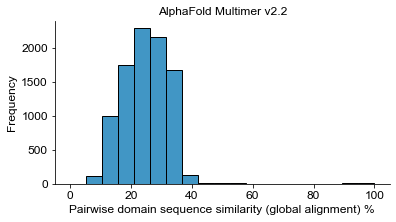

In [59]:
fig,ax = plt.subplots(figsize=(6,3))
sns.histplot(np.array(seq_similarity)*100,bins=np.linspace(start=0,stop=100,num=20),ax=ax)

modify_ticks_and_labels(ax, x_major_multiple=20, x_minor_multiple=20, y_major_multiple=500, y_minor_multiple=500)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.ylabel('Frequency', fontsize=global_fontsize)
plt.xlabel('Pairwise domain sequence similarity (global alignment) %', fontsize=global_fontsize)
# plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
#          fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2',fontsize=global_fontsize)

plt.savefig(f'{save_path}PRS_pairwise_sequence_similarity.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}PRS_pairwise_sequence_similarity.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()